In [1]:
# Dependencies and Setup
import numpy as np
import pandas as pd
import pytz

import os 
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import hvplot

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the CSV file located on BPD website into a Pandas DataFrame
arrest_data_df = pd.read_csv("Data/BPD_Arrests.csv")
# Display data
arrest_data_df.head()

,X,Y,arrestnumber,age,gender,race,arrestdatetime,arrestlocation,incidentoffence,incidentlocation,...,chargedescription,district,post,neighborhood,latitude,longitude,geolocation,incidentnumber,objectid,shape
0,1.401347e+06,608148.870493,23000037.0,39.0,M,B,2022/12/31 23:50:00+00,4000 OAKFORD ST,Unknown Offense,4000 OAKFORD ST,...,HGV,Northwest,621,West Arlington,39.3361,-76.6853,"(39.3361,-76.6853)",22L09338,1,NaN
1,1.401347e+06,608148.870493,23000039.0,50.0,M,B,2022/12/31 23:50:00+00,4000 OAKFORD ST,Unknown Offense,4000 OAKFORD ST,...,HGV,Northwest,621,West Arlington,39.3361,-76.6853,"(39.3361,-76.6853)",22L09338,2,NaN
2,NaN,NaN,23000010.0,27.0,M,B,2022/12/31 23:40:00+00,NaN,Unknown Offense,NaN,...,FAILURE TO APPEAR,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,3,NaN
3,1.417636e+06,595206.835862,23000050.0,42.0,M,B,2022/12/31 23:15:00+00,500 DOLPHIN ST,Unknown Offense,500 DOLPHIN ST,...,HGV,Central,123,Upton,39.3004,-76.6279,"(39.3004,-76.6279)",22L09343,4,NaN
4,NaN,NaN,22157188.0,31.0,M,B,2022/12/31 21:00:00+00,NaN,Unknown Offense,NaN,...,FAILURE TO APPEAR,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,5,NaN


In [3]:
# Define the desired time frame
start_date = pd.Timestamp("2018-01-01", tz="US/Eastern")
end_date = pd.Timestamp("2022-12-31", tz="US/Eastern")

# Convert date values to EST timezone
arrest_data_df["arrestdatetime"] = pd.to_datetime(arrest_data_df["arrestdatetime"], utc=False)

# Filter the data based on the time frame
sample_arrests = (arrest_data_df["arrestdatetime"] >= start_date) & (arrest_data_df["arrestdatetime"] <= end_date)

# Apply the filter to get the narrowed down data
narrowed_data = arrest_data_df[sample_arrests]
narrowed_data


,X,Y,arrestnumber,age,gender,race,arrestdatetime,arrestlocation,incidentoffence,incidentlocation,...,chargedescription,district,post,neighborhood,latitude,longitude,geolocation,incidentnumber,objectid,shape
18,NaN,NaN,22157121.0,32.0,F,W,2022-12-31 03:53:00+00:00,NaN,Unknown Offense,NaN,...,FAILURE TO APPEAR,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,19,NaN
19,1.432299e+06,594505.863803,22157116.0,19.0,M,B,2022-12-31 00:09:00+00:00,600 CURLY ST,Unknown Offense,600 CURLY ST,...,MOTOR VEHICLE THEFT,Southeast,224,Ellwood Park/Monument,39.2983,-76.5761,"(39.2983,-76.5761)",22L07944,20,NaN
20,1.407598e+06,592946.031158,22000022.0,18.0,M,B,2021-12-31 23:14:00+00:00,2800 EDMONDSON AVE,Unknown Offense,2800 EDMONDSON AVE,...,HGV,Western,721,Penrose/Fayette Street Outreach,39.2943,-76.6634,"(39.2943,-76.6634)",NaN,21,NaN
21,1.425747e+06,617095.607199,22000010.0,26.0,M,B,2021-12-31 22:09:00+00:00,5700 NORTHWOOD DR,Unknown Offense,5700 NORTHWOOD DR,...,HGV,Northern,523,Chinquapin Park,39.3604,-76.5989,"(39.3604,-76.5989)",NaN,22,NaN
22,NaN,NaN,21168317.0,24.0,M,B,2021-12-31 21:00:00+00:00,NaN,Unknown Offense,NaN,...,RAPE SECOND DEGREE,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,23,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361706,1.427588e+06,603736.077990,18000078.0,23.0,F,B,2018-01-01 10:00:00+00:00,1600 E. 28TH ST,4ECOMMON ASSAULT,1600 E. 28TH ST,...,ASSAULT,Northeast,411,Coldstream Homestead Montebello,39.3237,-76.5926,"(39.3237,-76.5926)",18A00107,361707,NaN
361707,NaN,NaN,18000050.0,29.0,F,W,2018-01-01 09:45:00+00:00,NaN,Unknown Offense,NaN,...,CDS:POSSESS-NOT MARIJUANA,NaN,NaN,NaN,NaN,NaN,"(,)",NaN,361708,NaN
361708,1.432485e+06,603102.765099,18000045.0,46.0,M,B,2018-01-01 08:00:00+00:00,3200 HARWELL AVE,79OTHER,3200 HARWELL AVE,...,AGG. ASSAULT,Northeast,432,Belair-Edison,39.3219,-76.5753,"(39.3219,-76.5753)",18A00083,361709,NaN
361709,1.420414e+06,600936.840992,18000038.0,58.0,M,B,2018-01-01 05:30:00+00:00,2300 MARYLAND AVE,5DBURG. OTH. (FORCE),2300 MARYLAND AVE,...,COMMON ASSAULT,Northern,514,Old Goucher,39.3161,-76.6180,"(39.3161,-76.618)",18E00079,361710,NaN


In [4]:
####Analysis by Offense Type

In [5]:
# Remove rows where 'chargedescription' is 'Unknown Charge'
narrowed_data = narrowed_data[narrowed_data['chargedescription'] != 'Unknown Charge']


In [46]:
# Copy the narrowed_data DataFrame
grouped_charges = narrowed_data.copy()

# Group together repetetive charge descriptions for cleaner data

#Combine all the assault descriptions
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('assault', case=False), 'chargedescription'] = 'Assault Charges'

# #combine all the narcotic descriptions
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('cds', case=False), 'chargedescription'] = 'Narcotic Charges'

# #combine all the handgun descriptions
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('HGV|handgun', case=False), 'chargedescription'] = 'Handgun Charges'

# #Combine all the robbery charge descriptions
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('robbery', case=False), 'chargedescription'] = 'Robbery Charges'

# #Combine all the larceny descriptions
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('larceny|theft', case=False), 'chargedescription'] = 'Larceny Charges'

# #Combine all the burglary charge descriptions
grouped_charges.loc[grouped_charges['chargedescription'].str.contains('burglary', case=False), 'chargedescription'] = 'Burglary Charges'


In [47]:
# Filter the top 10 charges for comparison based on charge description
top_10_charges = grouped_charges["chargedescription"].value_counts().nlargest(10).index
filtered_data = grouped_charges[grouped_charges["chargedescription"].isin(top_10_charges)]

In [48]:
# Extract month and year from the `arrestdatetime` column
filtered_data["arrest_month"] = filtered_data["arrestdatetime"].dt.month
filtered_data["arrest_year"] = filtered_data["arrestdatetime"].dt.year
pd.set_option('display.precision', 0)

# Group the data by month and year and count the number of arrests
arrest_counts = filtered_data.groupby(["arrest_month", "arrest_year"]).size().reset_index(name="arrest_count")

In [9]:
# Group the data by year and charge description and count the number of arrests
charge_count = filtered_data.groupby(["arrest_year", "chargedescription"]).size().reset_index(name="arrest_count")


,arrest_year,chargedescription,arrest_count
0,2018,Assault Charges,4585
1,2018,Burglary Charges,510
2,2018,DETAIN ONLY,309
3,2018,FAILURE TO APPEAR,3785
4,2018,Handgun Charges,923
5,2018,Larceny Charges,722
6,2018,Narcotic Charges,4251
7,2018,Robbery Charges,587
8,2018,STOLEN AUTO,312
9,2018,VIOLATION OF PROBATION,527


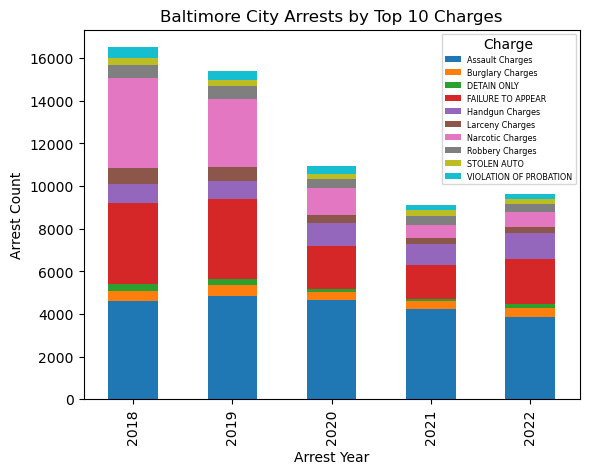

In [14]:
# Plot your data in a stacked bar chart
charge_count.pivot(index='arrest_year', columns='chargedescription', values='arrest_count').plot(kind='bar', stacked=True)

# Label the x and y axis
plt.title("Baltimore City Arrests by Top 10 Charges")
plt.xlabel("Arrest Year")
plt.ylabel("Arrest Count")

# Format the legend
plt.legend(title="Charge", loc=1, fontsize='xx-small', fancybox=True)
# Show the plot
plt.show()

In [15]:
# Isolate top 3 charges for better line graph readability
top_3_charges=charge_count.loc[charge_count['chargedescription'].isin(['Assault Charges', 'Narcotic Charges', 'FAILURE TO APPEAR'])]
top_3_charges.head()

,arrest_year,chargedescription,arrest_count
0,2018,Assault Charges,4585
3,2018,FAILURE TO APPEAR,3785
6,2018,Narcotic Charges,4251
10,2019,Assault Charges,4865
13,2019,FAILURE TO APPEAR,3756


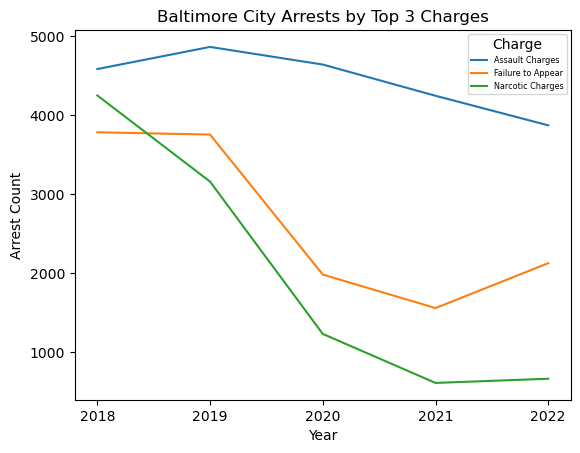

In [45]:
# Plot the top 3 offense charges (by count).  We are only doing top 3 here because of their positions on the line graph
top_3_charges.pivot(index='arrest_year', columns='chargedescription').plot(kind='line')

# Customize the legend
legend = plt.legend(title="Charge", loc=1, fontsize='xx-small', fancybox=True)
legend.texts[0].set_text('Assault Charges')
legend.texts[1].set_text('Failure to Appear')
legend.texts[2].set_text('Narcotic Charges')

# Label the axis
plt.title("Baltimore City Arrests by Top 3 Charges")
plt.xlabel("Year")
plt.ylabel("Arrest Count")

# Define tick labels
x_ticks = np.arange(min(bottom_7_charges['arrest_year']), max(bottom_7_charges['arrest_year']) + 1, 1.0)
plt.xticks(x_ticks)

# Show the plot
plt.show()


In [19]:
# Isolating lower charges for better graph readability
bottom_7_charges=charge_count.loc[charge_count['chargedescription'].isin(['Robbery Charges', 'Burglary Charges', 'Larceny Charges', 'Handgun Charges', 'STOLEN AUTO', 'VIOLATION OF PROBATION', 'DETAIN ONLY']) ]
bottom_7_charges.head()

,arrest_year,chargedescription,arrest_count
1,2018,Burglary Charges,510
2,2018,DETAIN ONLY,309
4,2018,Handgun Charges,923
5,2018,Larceny Charges,722
7,2018,Robbery Charges,587


Text(0, 0.5, 'Arrest Count')

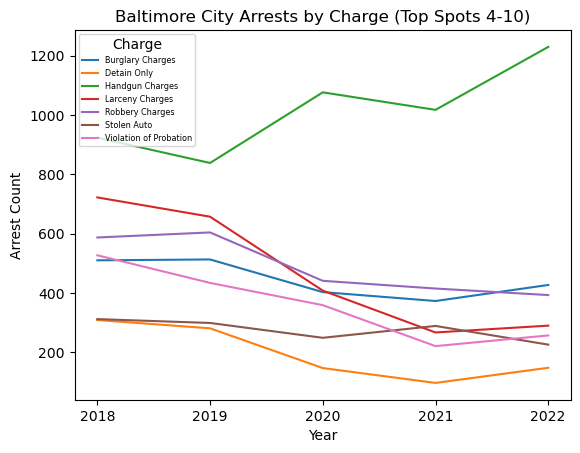

In [44]:
#Plot the lower 'Top 10' (bottom 7) by charge count
bottom_7_charges.pivot(index='arrest_year', columns='chargedescription').plot(kind='line')

# Customize the legend
legend = plt.legend(title="Charge",
                    loc=3, fontsize='small', fancybox=True)
legend = plt.legend(title="Charge", loc=2, fontsize='xx-small', fancybox=True)
legend.texts[0].set_text('Burglary Charges')
legend.texts[1].set_text('Detain Only')
legend.texts[2].set_text('Handgun Charges')
legend.texts[3].set_text('Larceny Charges')
legend.texts[4].set_text('Robbery Charges')
legend.texts[5].set_text('Stolen Auto')
legend.texts[6].set_text('Violation of Probation')

# Define tick labels
x_ticks = np.arange(min(bottom_7_charges['arrest_year']), max(bottom_7_charges['arrest_year']) + 1, 1.0)
plt.xticks(x_ticks)

# Label the x and y axis and Title
plt.title("Baltimore City Arrests by Charge (Top Spots 4-10)")
plt.xlabel("Year")
plt.ylabel("Arrest Count")

In [23]:
####Temporal Analysis

In [24]:
# Extract month and year from the `arrestdatetime` column
narrowed_data["arrest_month"] = narrowed_data["arrestdatetime"].dt.month
narrowed_data["arrest_year"] = narrowed_data["arrestdatetime"].dt.year
pd.set_option('display.precision', 0)

# Group the data by month and year and count the number of arrests
arrest_counts = narrowed_data.groupby(["arrest_month", "arrest_year"]).size().reset_index(name="arrest_count")


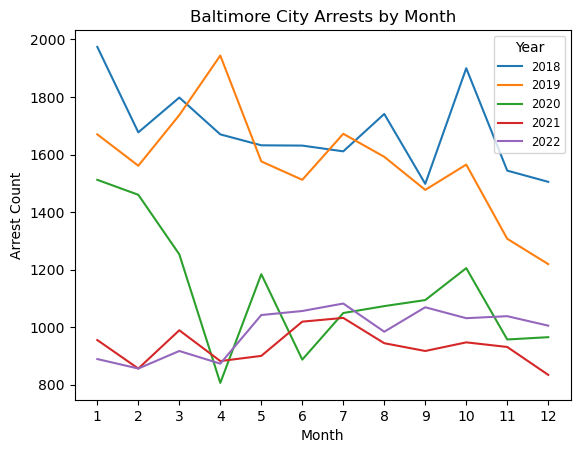

In [25]:
# Group month and year for arrest counts
arrest_counts_grouped = arrest_counts.groupby(['arrest_month', 'arrest_year']).sum().reset_index()

# Convert 'arrest_year' column to integers
arrest_counts_grouped['arrest_year'] = arrest_counts_grouped['arrest_year'].astype(int)

# Plot the grouped data
arrest_counts_grouped.pivot(index='arrest_month', columns='arrest_year', values='arrest_count').plot(kind='line')

# Assign labels and titles
plt.title("Baltimore City Arrests by Month")
plt.xlabel("Month")
plt.ylabel("Arrest Count")
legend = plt.legend(title="Year",
                    loc=1, fontsize='small', fancybox=True)

#add tick marks for months
months = np.arange(1, 13)  
plt.xticks(months)

# Display the plot
plt.show()


In [26]:
# Group month and year into a single column for mapping
cols = ['arrest_month', 'arrest_year']
month_year = arrest_counts_grouped[cols].astype(int).apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Name the column
month_year = month_year.rename('month_year')


In [30]:
#Combine the two datasets to create one dataset with the newly combined 'month_year'
five_year = pd.concat([arrest_counts, month_year], axis=1)

# Sort the DataFrame by the 'arrest_year' column in descending order
five_year = five_year.sort_values(by='arrest_year', ascending=True)


In [31]:
# Sort the DataFrame by the 'arrest_year' and 'arrest_month' columns in ascending order
five_year = five_year.sort_values(by=['arrest_year', 'arrest_month'], ascending=True)
#five_year = five_year.astype(int)


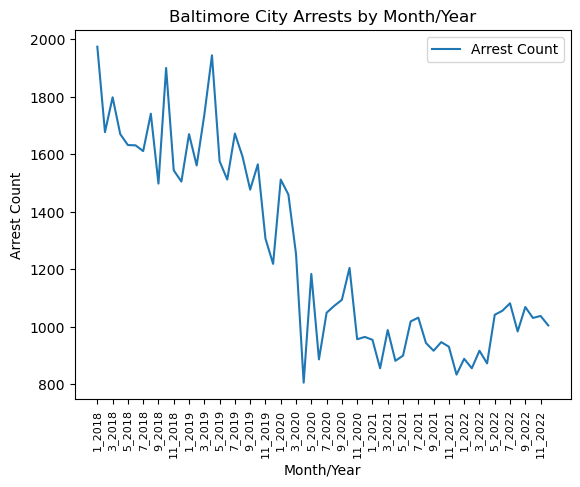

In [43]:
# Group month and year
arrest_counts_grouped = arrest_counts.groupby(['arrest_month', 'arrest_year']).sum().reset_index()

# Plotting the grouped data
plt.xticks(x_ticks, five_year['month_year'].iloc[x_ticks], fontsize=8)

# Set the x-axis tick labels
x_ticks = np.arange(0, len(five_year), 2)
plt.xticks(x_ticks, five_year['month_year'].iloc[x_ticks])

# Plot the data with label
plt.plot(five_year['month_year'], five_year['arrest_count'], label='Arrest Count')
plt.xticks(rotation=90)

# Assign the title, label the x and y-axis
plt.title("Baltimore City Arrests by Month/Year")
plt.xlabel("Month/Year")
plt.ylabel("Arrest Count")

# Show the legend
plt.legend()

# Show the plot
plt.show()